

We will consider multiple popular models:

- **classification and regression trees**, CART -- a model that is conceptually different from regression since it does not have coefficients. We will see that this method is helpful for visualization and understanding, but not most accurate for predictions

- tree **ensemble models**, including some of the most popular machine learning methods, random forest and gradient boosting, which combine multiple trees. Random forest builds many trees in parallels, xgboost builds them in sequence

- **support vector machines** -- a method somewhat in-between regressions and trees that fits lower-dimensional planes to separate the data into classes with maximal margin between them


### Step 0: To start ... 

In [1]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


# Steps 1 and 2: Install and load the necessary packages and libraries

Make sure that the necessary packages and libraries are loaded.

In [2]:

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

# Step 3: Load the data

Load the data from the corresponding Excel data file and examine its structure.

In [3]:
# Before loading the data, we should first upload the data for this exercise to Google Colab. This step can be omitted if the code is run locally. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Load Dataset.
data = pd.read_excel('/content/drive/My Drive/Prof/Machine Learning Projects/Data Sets/Shipment Data.xlsx')

# Explore snippet of data
print(data.info())
print(data.head())

# Exploring Target Variable
y = data['refined_shipment_mode']
unique, counts = np.unique(y, return_counts=True) # 3 distinct classes equally represented
print("The frequency of instances per class is: " , dict(zip(unique, counts)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103171 entries, 0 to 103170
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   attribute4             101824 non-null  object 
 1   Carrier                103171 non-null  object 
 2   Reciever               103171 non-null  object 
 3   Destination            103171 non-null  object 
 4   Destination-country    103171 non-null  object 
 5   freight_term           103108 non-null  object 
 6   pack_type              103103 non-null  object 
 7   Product                103171 non-null  object 
 8   quantity_in_st         103171 non-null  float64
 9   Origin                 103171 non-null  object 
 10  Business               103171 non-null  object 
 11  refined_shipment_mode  103171 non-null  object 
dtypes: float64(1), object(11)
memory usage: 9.4+ MB
None
           attribute4     Carrier       Reciever      Destination  \
0  BERTSCHI-RAIL-BUL

# Step 4: "Cleaning" the data


1. Some datafields (variables, features, columns) have incotrect types -- they should be converted, for instance, from numbers to categoricals 
    
2. Some categorical variables have too many categories (levels), and some of the levels are too rare: such data should be merged into a more populous category
    
3. Some data are missing and we need to replace or impute them 

To conclude data cleaning we will, of course, have to create dummy variables ("one hot encoding") for the categorical variables
 

In [5]:
# "Cleaning" the data -- part 1: converting incorrect data types

# Some of python data types:
# int -- integer number (e.g., 5)
# float -- fractional number (e.g., 5.25)
# object, str -- text (string). A text that contains several unordered values (e.g., M/F) is called "category"

# Other data types in the pandas package:
# category -- categorical, same as "factor" in R (e.g., red/green/blue, or M/F: a list with several unordered values)
# datetime -- date and time (e.g., 01.01.2020)
# bool -- binary (e.g.? yes/no, 1/0)

# "Cleaning" the data -- part 1: converting data types that should be categorical into "category"

data['freight_term'] = data['freight_term'].astype('category')
data['Carrier'] = data['Carrier'].astype('category')
data['pack_type'] = data['freight_term'].astype('category')
data['Business'] = data['Business'].astype('category')
data['Reciever'] = data['Reciever'].astype('category')
data['Destination'] = data['Destination'].astype('category')
data['Destination-country'] = data['Destination-country'].astype('category')
data['Product'] = data['Product'].astype('category')
data['Origin'] = data['Origin'].astype('category')
data['refined_shipment_mode'] = data['refined_shipment_mode'].astype('category')




data.info() # let's check the result

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103171 entries, 0 to 103170
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   attribute4             101824 non-null  object  
 1   Carrier                103171 non-null  category
 2   Reciever               103171 non-null  category
 3   Destination            103171 non-null  category
 4   Destination-country    103171 non-null  category
 5   freight_term           103108 non-null  category
 6   pack_type              103108 non-null  category
 7   Product                103171 non-null  category
 8   quantity_in_st         103171 non-null  float64 
 9   Origin                 103171 non-null  category
 10  Business               103171 non-null  category
 11  refined_shipment_mode  103171 non-null  category
dtypes: category(10), float64(1), object(1)
memory usage: 3.1+ MB


In [6]:
# "Cleaning" the data -- part 2: extracting information from rare groups

#we can use a lambda function to achieve the new columns, as well as a for loop to iterate all the values we are looking for.

# Convert float values to string
data['attribute4'] = data['attribute4'].astype(str)

words_to_look_for = ['RAIL','BULK','TRUCK','LTL','OCEAN','AIR']

for item in words_to_look_for:
  column_name = str('Contains_' + item + '_attribute4')
  data[column_name] = data['attribute4'].apply(lambda text: 1 if item in text else 0)

#lets check our new columns as it relates to each unique value of attribute 4.
columns_to_group = ['attribute4','Contains_RAIL_attribute4','Contains_BULK_attribute4','Contains_TRUCK_attribute4','Contains_LTL_attribute4','Contains_OCEAN_attribute4','Contains_AIR_attribute4']

print(data.groupby(columns_to_group).count())


                                                                                                                                                                           Carrier  \
attribute4          Contains_RAIL_attribute4 Contains_BULK_attribute4 Contains_TRUCK_attribute4 Contains_LTL_attribute4 Contains_OCEAN_attribute4 Contains_AIR_attribute4            
2XLNV-TL-TRUCK      0                        0                        1                         0                       0                         0                            214   
40CONT_INT          0                        0                        0                         0                       0                         0                             53   
53CONT_INT          0                        0                        0                         0                       0                         0                            305   
AIR                 0                        0                        0                   

we can now drop the attribute4 column, where there were too many unique values and we managed to extract all the valuable information out of it.

In [7]:
data = data.drop('attribute4', axis=1)

# Step 5:  Defining the vector of target (y) and matrix of features (X)

In [8]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Assuming 'data' is a pandas DataFrame
X = data.drop('refined_shipment_mode', axis=1)
y = data['refined_shipment_mode'].replace({'AIR': 1, 'BULK TRUCK': 2, 'FCL-OCEAN': 3, 'FLATBED': 4, 'LCL-OCEAN': 5, 'LTL': 6, 'RAIL': 7, 'TANK TRUCK': 8, 'VAN': 9})

# Replace 'column_to_exclude' with the name of the column you don't want to encode
column_to_exclude = 'quantity_in_st'

# Get the index of the column to exclude
column_to_exclude_idx = X.columns.get_loc(column_to_exclude)

# Get the indices of the columns to encode
columns_to_encode_idx = [i for i in range(X.shape[1]) if i != column_to_exclude_idx]

# Instantiate the ColumnTransformer with OneHotEncoder for the desired columns
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(), columns_to_encode_idx)
    ],
    remainder='passthrough'  # Keep the remaining columns as they are (i.e., don't encode the excluded column)
)

# Fit and transform the data
X_encoded = preprocessor.fit_transform(X)






# Step 6:  Splitting X and y into training and testing

Split the data into testing and training. This is a very important step. Conceptually, because the goal of predictive modeling is not to build a model that fits well into the data it trains on, but rather one that would best predict the new data—a testing dataset is in this sense the best representation of what the “new data” may look like.

In [9]:
# For "apples-to-apples" comparisons, set a starting value ("seed") for the random number generator
np.random.seed(77300)

# split the data randomly into 80% train and 20% test samples 
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y, test_size = 0.20, stratify=y)
# IMPORTANT: these samples are stratified, i.e., the proportion of retained and not-retained customers is the same in both

# Lets check the result
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(82536, 4529)
(20635, 4529)
(82536,)
(20635,)


# Steps 7, 8, 9: Train a model on the training data, Use it to predict the values in the testing data, Compute the metrics of the model and compare models

In [10]:
# First we define a set of functions to compute the metrics of the model

# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

# Method №1: Classification and Regression Tree, CART (aka "decision tree")


In [11]:
# Define a CART model and call it classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 10, random_state=77300) # random_state -- is same as random seed, neede to get the same result every time we rerun

# Train the model classifier_DT on the training data
classifier_DT.fit(X_train, y_train)

#  Use the trained model to predict testing data
y_pred = classifier_DT.predict(X_test) # probabilities 


print(y_pred[0:5]) # resultant predicted classification 
print(y_test[0:5]) # actual outcomes




[2 9 9 2 2]
62296     2
101946    9
52236     9
9559      2
40864     2
Name: refined_shipment_mode, dtype: category
Categories (9, int64): [1, 2, 3, 4, ..., 6, 7, 8, 9]


CART tree with 10 leaves


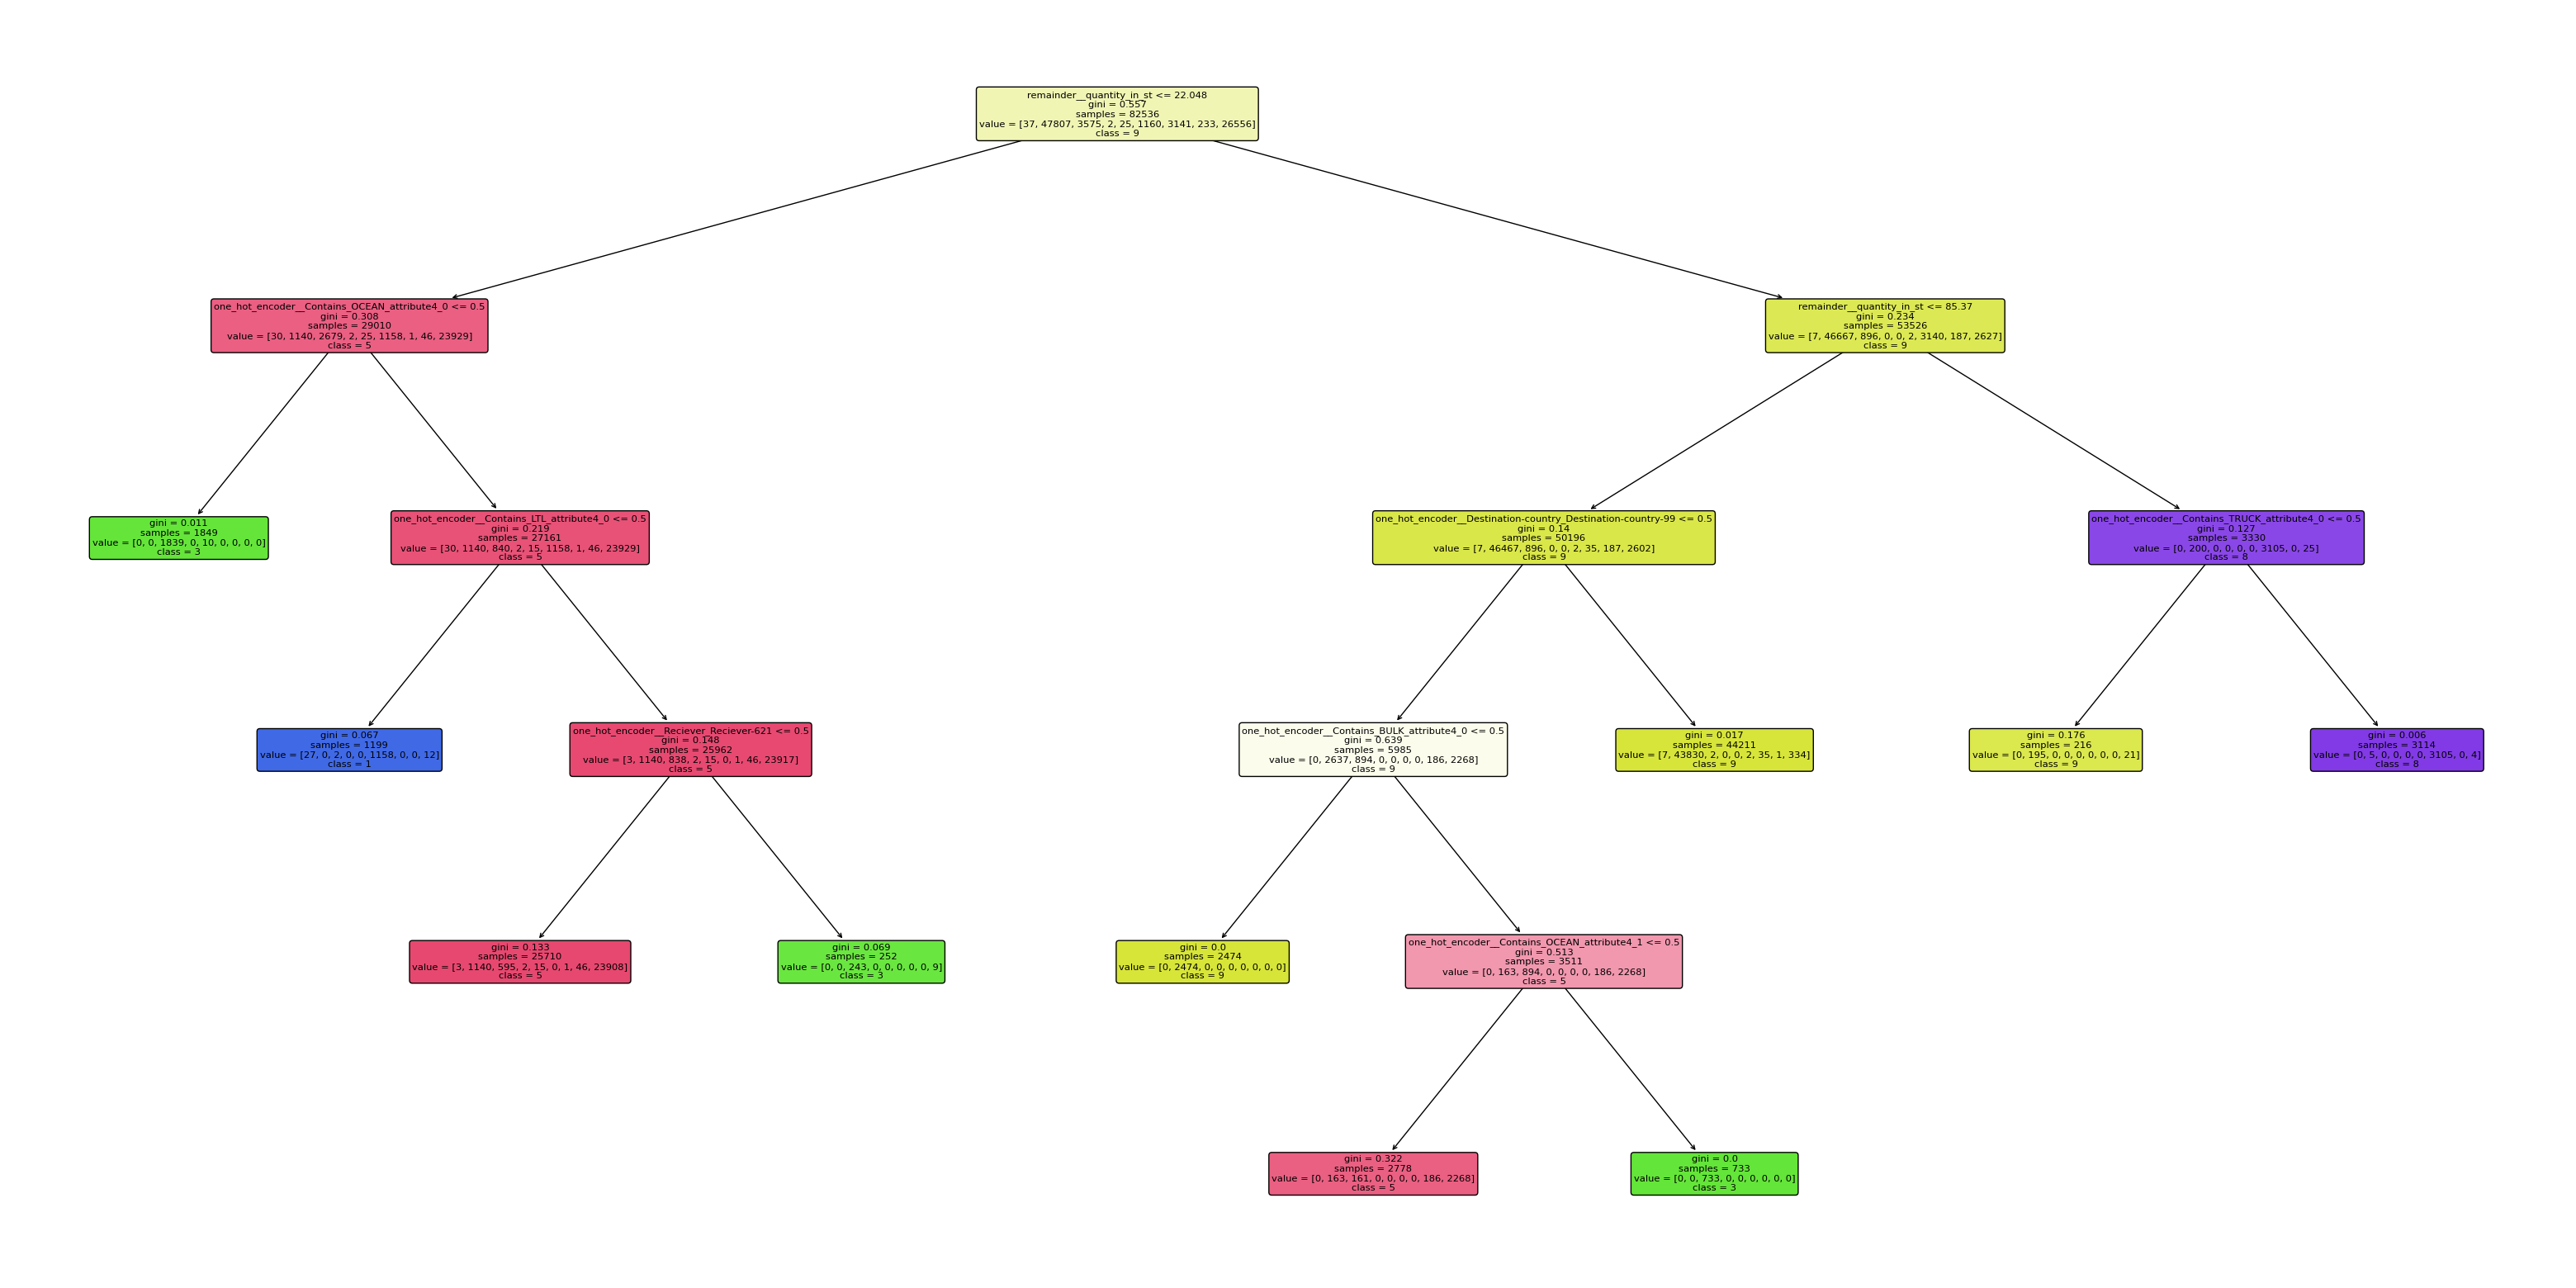

In [12]:
# Visualizing the resultant tree

from sklearn import tree

plt.figure(figsize=(40,20))
tree.plot_tree(classifier_DT.fit(X_train, y_train), feature_names=preprocessor.get_feature_names_out(), filled = True, 
               class_names = y.unique().astype(str), rounded = True)
print('CART tree with 10 leaves')


In [13]:
# Lets look at the model metrics

print('Metrics of the CART model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))


Metrics of the CART model: 

Confusion matrix: 
[[    0     0     0     0     0     0     0     0]
 [    1 11657     2     0     1     3     0    86]
 [    0     0   716     2     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    6     0     1     0   289     0     0     1]
 [    0     2     0     0     0   782     0     1]
 [    0     0     0     0     0     0     0     0]
 [    2   294   175     4     0     0    59  6551]]
                                   Accuracy: 0.9999142219934809
                   SENSITIVITY (aka RECALL): 1.0
                 SPECIFICITY (aka FALL-OUT): 0.0
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9999142219934809
                 NEGATIVE PREDICTIVE VALUE): nan


# Method №2: Random Forest

In [14]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=77300)

# Train the model classifier_RF on the training data
classifier_RF.fit(X_train, y_train)

# A random forest model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble, 
# -- voting rules, 
# -- max number of leaves on each tree, 
# -- min number of datapoints at a leaf
# and so on

RandomForestClassifier(random_state=77300)

In [15]:
# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # probabilities 


# Lets look at the model metrics

print('Metrics of the Random Forest model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))




Metrics of the Random Forest model: 

Confusion matrix: 
[[    0     0     0     0     0     0     0     0]
 [    1 11657     2     0     1     3     0    86]
 [    0     0   716     2     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    6     0     1     0   289     0     0     1]
 [    0     2     0     0     0   782     0     1]
 [    0     0     0     0     0     0     0     0]
 [    2   294   175     4     0     0    59  6551]]
                                   Accuracy: 0.9999142219934809
                   SENSITIVITY (aka RECALL): 1.0
                 SPECIFICITY (aka FALL-OUT): 0.0
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9999142219934809
                 NEGATIVE PREDICTIVE VALUE): nan


In [16]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

n_trees = [100, 200, 300, 400, 500, 600] # as an example, we will tune the "number of trees" hyper-parameter (n_trees) and we will consider values of 100, 200, ... 600 trees in the forest
Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ] 

# we will apply a 5-fold cross-validation and call the resultant function "grid_search"
grid_search = GridSearchCV(estimator = classifier_RF, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# apply function grid_search to the training data, call the result and best model grid_search_RF
grid_search_RF = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_RF.predict_proba(X_test)[:,1] # probabilities  

print('Optimized hyper-parameters:' + str(grid_search.best_params_))
    
# Lets look at the model metrics

print('Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))




Optimized hyper-parameters:{'n_estimators': 100}
Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": 

Confusion matrix: 
[[    0     0     0     0     0     0     0     0]
 [    1 11657     2     0     1     3     0    86]
 [    0     0   716     2     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    6     0     1     0   289     0     0     1]
 [    0     2     0     0     0   782     0     1]
 [    0     0     0     0     0     0     0     0]
 [    2   294   175     4     0     0    59  6551]]
                                   Accuracy: 0.9999142219934809
                   SENSITIVITY (aka RECALL): 1.0
                 SPECIFICITY (aka FALL-OUT): 0.0
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9999142219934809
                 NEGATIVE PREDICTIVE VALUE): nan


<Axes: title={'center': 'Feature Importance'}>

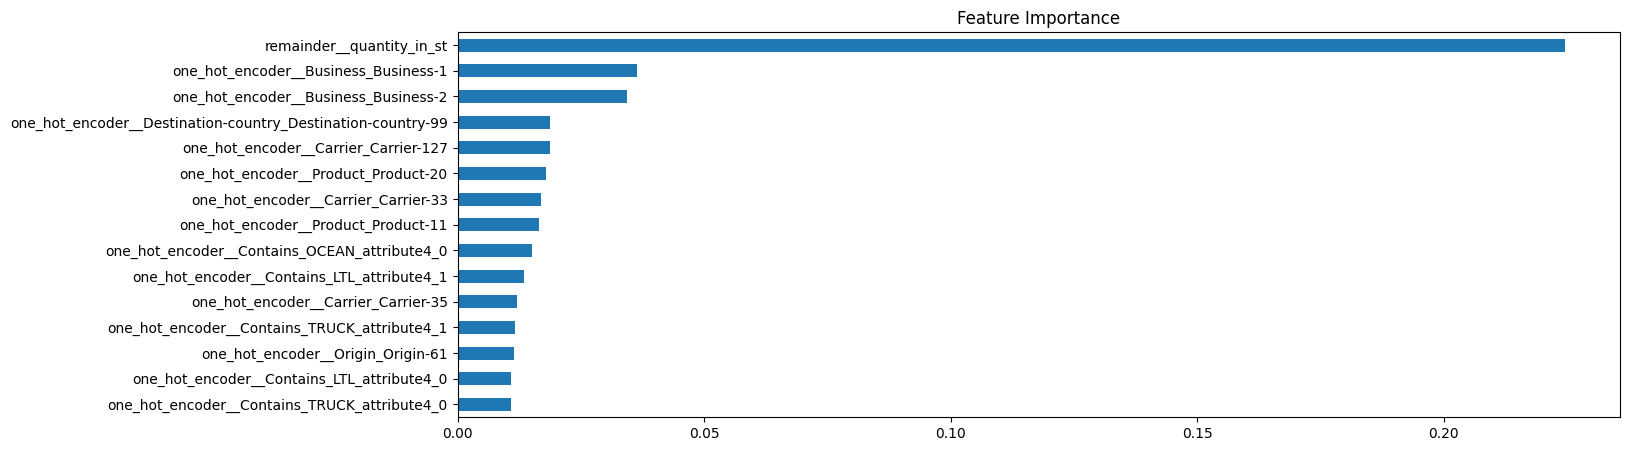

In [17]:
# Tree models do not have coefficients, but have easily-interpretable tree plots
# But in tree ensembles (such as random forest) there is no point to look at individual trees

# Useful intuition, however, can be obtained from the Feature Importance Plots

# calculate feature importances
importances = grid_search_RF.best_estimator_.feature_importances_ 

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=preprocessor.get_feature_names_out())
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

# Method №4: Gradient Boosting Machine

In [18]:
# Define the gradient boosting machine model and call it classifier_GBM
classifier_GBM = GradientBoostingClassifier(random_state=77300)

# Train the model classifier_GBM on the training data
classifier_GBM.fit(X_train, y_train)

# A gradient boosting model has many hyper-parameters, for example::
# -- the number of trees in the forest ensemble, 
# -- speed of boosting ("learning rate", "decay rate"), 
# -- max number of leaves on each tree, 
# -- min number of datapoints at a leaf
# and so on


GradientBoostingClassifier(random_state=77300)

In [19]:
# Use the trained model to predict testing data
y_pred_prob = classifier_GBM.predict_proba(X_test)[:,1] # probabilities 


# Lets look at the model metrics

print('Metrics of the Gradient Boosting Machine model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))


Metrics of the Gradient Boosting Machine model: 

Confusion matrix: 
[[    0     0     0     0     0     0     0     0]
 [    1 11657     2     0     1     3     0    86]
 [    0     0   716     2     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    6     0     1     0   289     0     0     1]
 [    0     2     0     0     0   782     0     1]
 [    0     0     0     0     0     0     0     0]
 [    2   294   175     4     0     0    59  6551]]
                                   Accuracy: 0.9999142219934809
                   SENSITIVITY (aka RECALL): 1.0
                 SPECIFICITY (aka FALL-OUT): 0.0
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9999142219934809
                 NEGATIVE PREDICTIVE VALUE): nan


# Method №5: Support Vector Machines

In [20]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_estimators = []
svm_estimators.append(('standardize', StandardScaler(with_mean=False))) # scale the data
svm_estimators.append(('svm', svm.SVC(probability=True))) # define SVM with probabilities (recall, SVM be default does not predict probabilities)
     
# Define the support vectors machine model and call it classifier_SVM
Classifier_SVM = Pipeline(svm_estimators, verbose=False)

# Train the model classifier_SVM on the training data
Classifier_SVM.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler(with_mean=False)),
                ('svm', SVC(probability=True))])

In [21]:
# use the fitted model to predict the testing data 
y_pred_prob = Classifier_SVM.predict_proba(X_test)[:,1] # probabilities


# Lets look at the model metrics

print('Metrics of the Support Vector Machines model: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))


Metrics of the Support Vector Machines model: 

Confusion matrix: 
[[    0     0     0     0     0     0     0     0]
 [    1 11657     2     0     1     3     0    86]
 [    0     0   716     2     0     0     0     0]
 [    0     0     0     0     0     0     0     0]
 [    6     0     1     0   289     0     0     1]
 [    0     2     0     0     0   782     0     1]
 [    0     0     0     0     0     0     0     0]
 [    2   294   175     4     0     0    59  6551]]
                                   Accuracy: 0.9999142219934809
                   SENSITIVITY (aka RECALL): 1.0
                 SPECIFICITY (aka FALL-OUT): 0.0
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.9999142219934809
                 NEGATIVE PREDICTIVE VALUE): nan
